# Imports

In [1]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from pandas_profiling import ProfileReport 

%matplotlib inline
sns.set()

from math import ceil

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV, LassoCV, RidgeCV

# Reading the Data

In [2]:
df = pd.read_csv('donors.csv', header=0, index_col=[0,'CONTROLN'], low_memory=False, 
                 dtype={'TCODE':'str','HPHONE_D':'str','RFA_2F':'str','WEALTH1':'str','WEALTH2':'str','INCOME':'str'})
df.head()

,,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TIMELAG,AVGGIFT,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
,CONTROLN,,,,,,,,,,,,,,,,,,,,,
0,95515,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,,...,4.0,7.741935,0,L,4,E,X,X,X,C
1,148535,2014-01-01,BOA,1,CA,91326,,,1972-02-01,0,,...,18.0,15.666667,0,L,2,G,X,X,X,A
2,15078,2010-01-01,AMH,1,NC,27017,,,NaN,0,,...,12.0,7.481481,1,L,4,E,X,X,X,C
3,172556,2007-01-01,BRY,0,CA,95953,,,1948-01-01,0,,...,9.0,6.812500,1,L,4,E,X,X,X,C
4,7112,2006-01-01,,0,FL,33176,,,1940-01-01,0,X,...,14.0,6.864865,1,L,2,F,X,X,X,A


In [3]:
df.shape

(95412, 474)

# Initial Analysis

In [4]:
# Checking for duplicates:
df.duplicated().sum()

0

In [5]:
# check df data types:
df.dtypes

ODATEDW     object
OSOURCE     object
TCODE       object
STATE       object
ZIP         object
             ...  
RFA_2A      object
MDMAUD_R    object
MDMAUD_F    object
MDMAUD_A    object
GEOCODE2    object
Length: 474, dtype: object

In [6]:
# replace "" by nans:
df.replace("", np.nan, inplace=True)

In [7]:
# Dealing with the white spaces where they aren´t supposed to be according to the MetaData:
lista = []
for column in df.columns:
    if (df[column].isin([' ']).sum()>0):
        lista.append(column)
# Decide which ones to replace by NaN or not 
for feature in lista:
    print(df[feature].value_counts())        

#variables in which i´ll replace the ' ' by Nan:
to_be_replaced=['OSOURCE','PVASTATE','DOMAIN','HOMEOWNR','GENDER','DATASRCE','RFA_3','RFA_4','RFA_5','RFA_6','RFA_7','RFA_8',
                'RFA_9','RFA_10','RFA_11','RFA_12','RFA_13','RFA_14','RFA_15','RFA_16','RFA_17','RFA_18','RFA_19','RFA_20',
               'RFA_21','RFA_22','RFA_23','RFA_24']

for feature in to_be_replaced:
    df[feature].replace(" ", np.nan, inplace=True)
# CHILD12 e assim considerei o ' 'como ausencia de filhos e nao como missing values
# na variavel gender aparecem 2 categorias que não estao na metadata: 'A' e 'C'


# NAS VARIAVEIS  COLLECT1 O ' ' É A CATEGORIA 'N' DA METADATA CERTO?:
for feature in df.columns[52:70]:
    df[feature].replace(" ", 'N', inplace=True)

MBC    4539
SYN    3563
AML    3430
BHG    3324
IMP    2986
       ... 
EAR       1
MRC       1
USU       1
STU       1
INC       1
Name: OSOURCE, Length: 896, dtype: int64
     94013
B     1399
Name: MAILCODE, dtype: int64
     93954
P     1453
E        5
Name: PVASTATE, dtype: int64
0    95085
1      285
X       35
         7
Name: NOEXCH, dtype: int64
     88709
X     6703
Name: RECINHSE, dtype: int64
     93395
X     2017
Name: RECP3, dtype: int64
     95298
X      114
Name: RECPGVG, dtype: int64
     93795
X     1617
Name: RECSWEEP, dtype: int64
R2    13623
T2    12369
S1    11503
S2     8530
C2     8264
C1     6145
C3     5280
T1     4982
R3     4809
U1     4510
U2     3254
U3     2598
       2316
T3     2176
S3     1891
U4     1804
R1     1358
Name: DOMAIN, dtype: int64
H    52354
     22228
U    20830
Name: HOMEOWNR, dtype: int64
     94266
M      869
F      237
B       40
Name: CHILD03, dtype: int64
     93846
M     1061
F      408
B       97
Name: CHILD07, dtype: int64
     9

In [8]:
# sorted count of missing values:
df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending=False)

RAMNT_5     95403
RDATE_5     95403
RDATE_3     95170
RAMNT_3     95170
RAMNT_4     95131
            ...  
MSA           132
ADI           132
DMA           132
GEOCODE2      132
FISTDATE        2
Length: 120, dtype: int64

In [9]:
# checking descriptive statistics:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
NUMCHLD,12386.0,1.527773,0.806861,1.000000,1.000000,1.000000,2.000000,7.0
HIT,95412.0,3.321438,9.306899,0.000000,0.000000,0.000000,3.000000,241.0
MBCRAFT,42558.0,0.152075,0.470023,0.000000,0.000000,0.000000,0.000000,6.0
MBGARDEN,42558.0,0.059166,0.262078,0.000000,0.000000,0.000000,0.000000,4.0
MBBOOKS,42558.0,1.116382,1.669967,0.000000,0.000000,0.000000,2.000000,9.0
...,...,...,...,...,...,...,...,...
MINRAMNT,95412.0,7.933656,8.784231,0.000000,3.000000,5.000000,10.000000,1000.0
MAXRAMNT,95412.0,19.999790,25.067746,5.000000,14.000000,17.000000,23.000000,5000.0
LASTGIFT,95412.0,17.313127,13.956630,0.000000,10.000000,15.000000,20.000000,1000.0
TIMELAG,85439.0,8.093739,8.213242,0.000000,4.000000,6.000000,11.000000,1088.0


### Feature Engineering

In [10]:
df["ODATEDW"] = df["ODATEDW"].apply(lambda x: x[:7])

In [11]:
df['DOB'] = df['DOB'].apply(lambda x: int(str(x)[:4]) if (str(x)!='nan') else None)
df['DOB'] = 2020 - df['DOB']
df.rename(columns={'DOB':'Age'},inplace=True)

## Missing Values

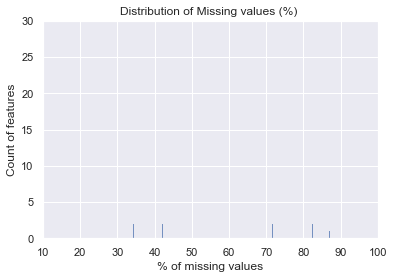

In [12]:
# Plotting the distribution of missing values(greater than 10%)
ax = sns.histplot(df.isnull().mean()*100, bins='auto')
ax.set_title('Distribution of Missing values (%) ')
ax.set(xlabel='% of missing values', ylabel='Count of features',xlim=(10,100),ylim=(0,30))
# Colloring red the bars that represent the count of features with % of missing values >= 50% :
for i in range(5,10):
    ax.patches[i].set_color('r')
    ax.patches[i].set_linestyle(':')
plt.show(ax)

### Removing the features that have missing values

We are removing all the columns that have more than 50% of Missing Values

### Nota: Ver as ADATES

In [13]:
cols = df.columns[df.isnull().mean() > 0.5]

display(pd.DataFrame(df[cols].isnull().mean()*100, columns=['% Missing Values']).sort_values(by='% Missing Values',ascending=False))

df = df.drop(cols, axis=1)

,% Missing Values
RDATE_5,99.990567
RAMNT_5,99.990567
RAMNT_3,99.746363
RDATE_3,99.746363
RDATE_4,99.705488
...,...
PUBCULIN,55.395548
PUBNEWFN,55.395548
PUBHLTH,55.395548
ADATE_20,52.613927


#### Metric and Non-Metric Variables:

In [14]:
def update_metric_feat(df):
    metric_features = df.select_dtypes(include=np.number).columns
    non_metric_features = df.select_dtypes(exclude=np.number).columns
    return metric_features.tolist(),non_metric_features.tolist()

metric_features = update_metric_feat(df)[0]
non_metric_features = update_metric_feat(df)[1]

## Outliers

#### Box Plots:

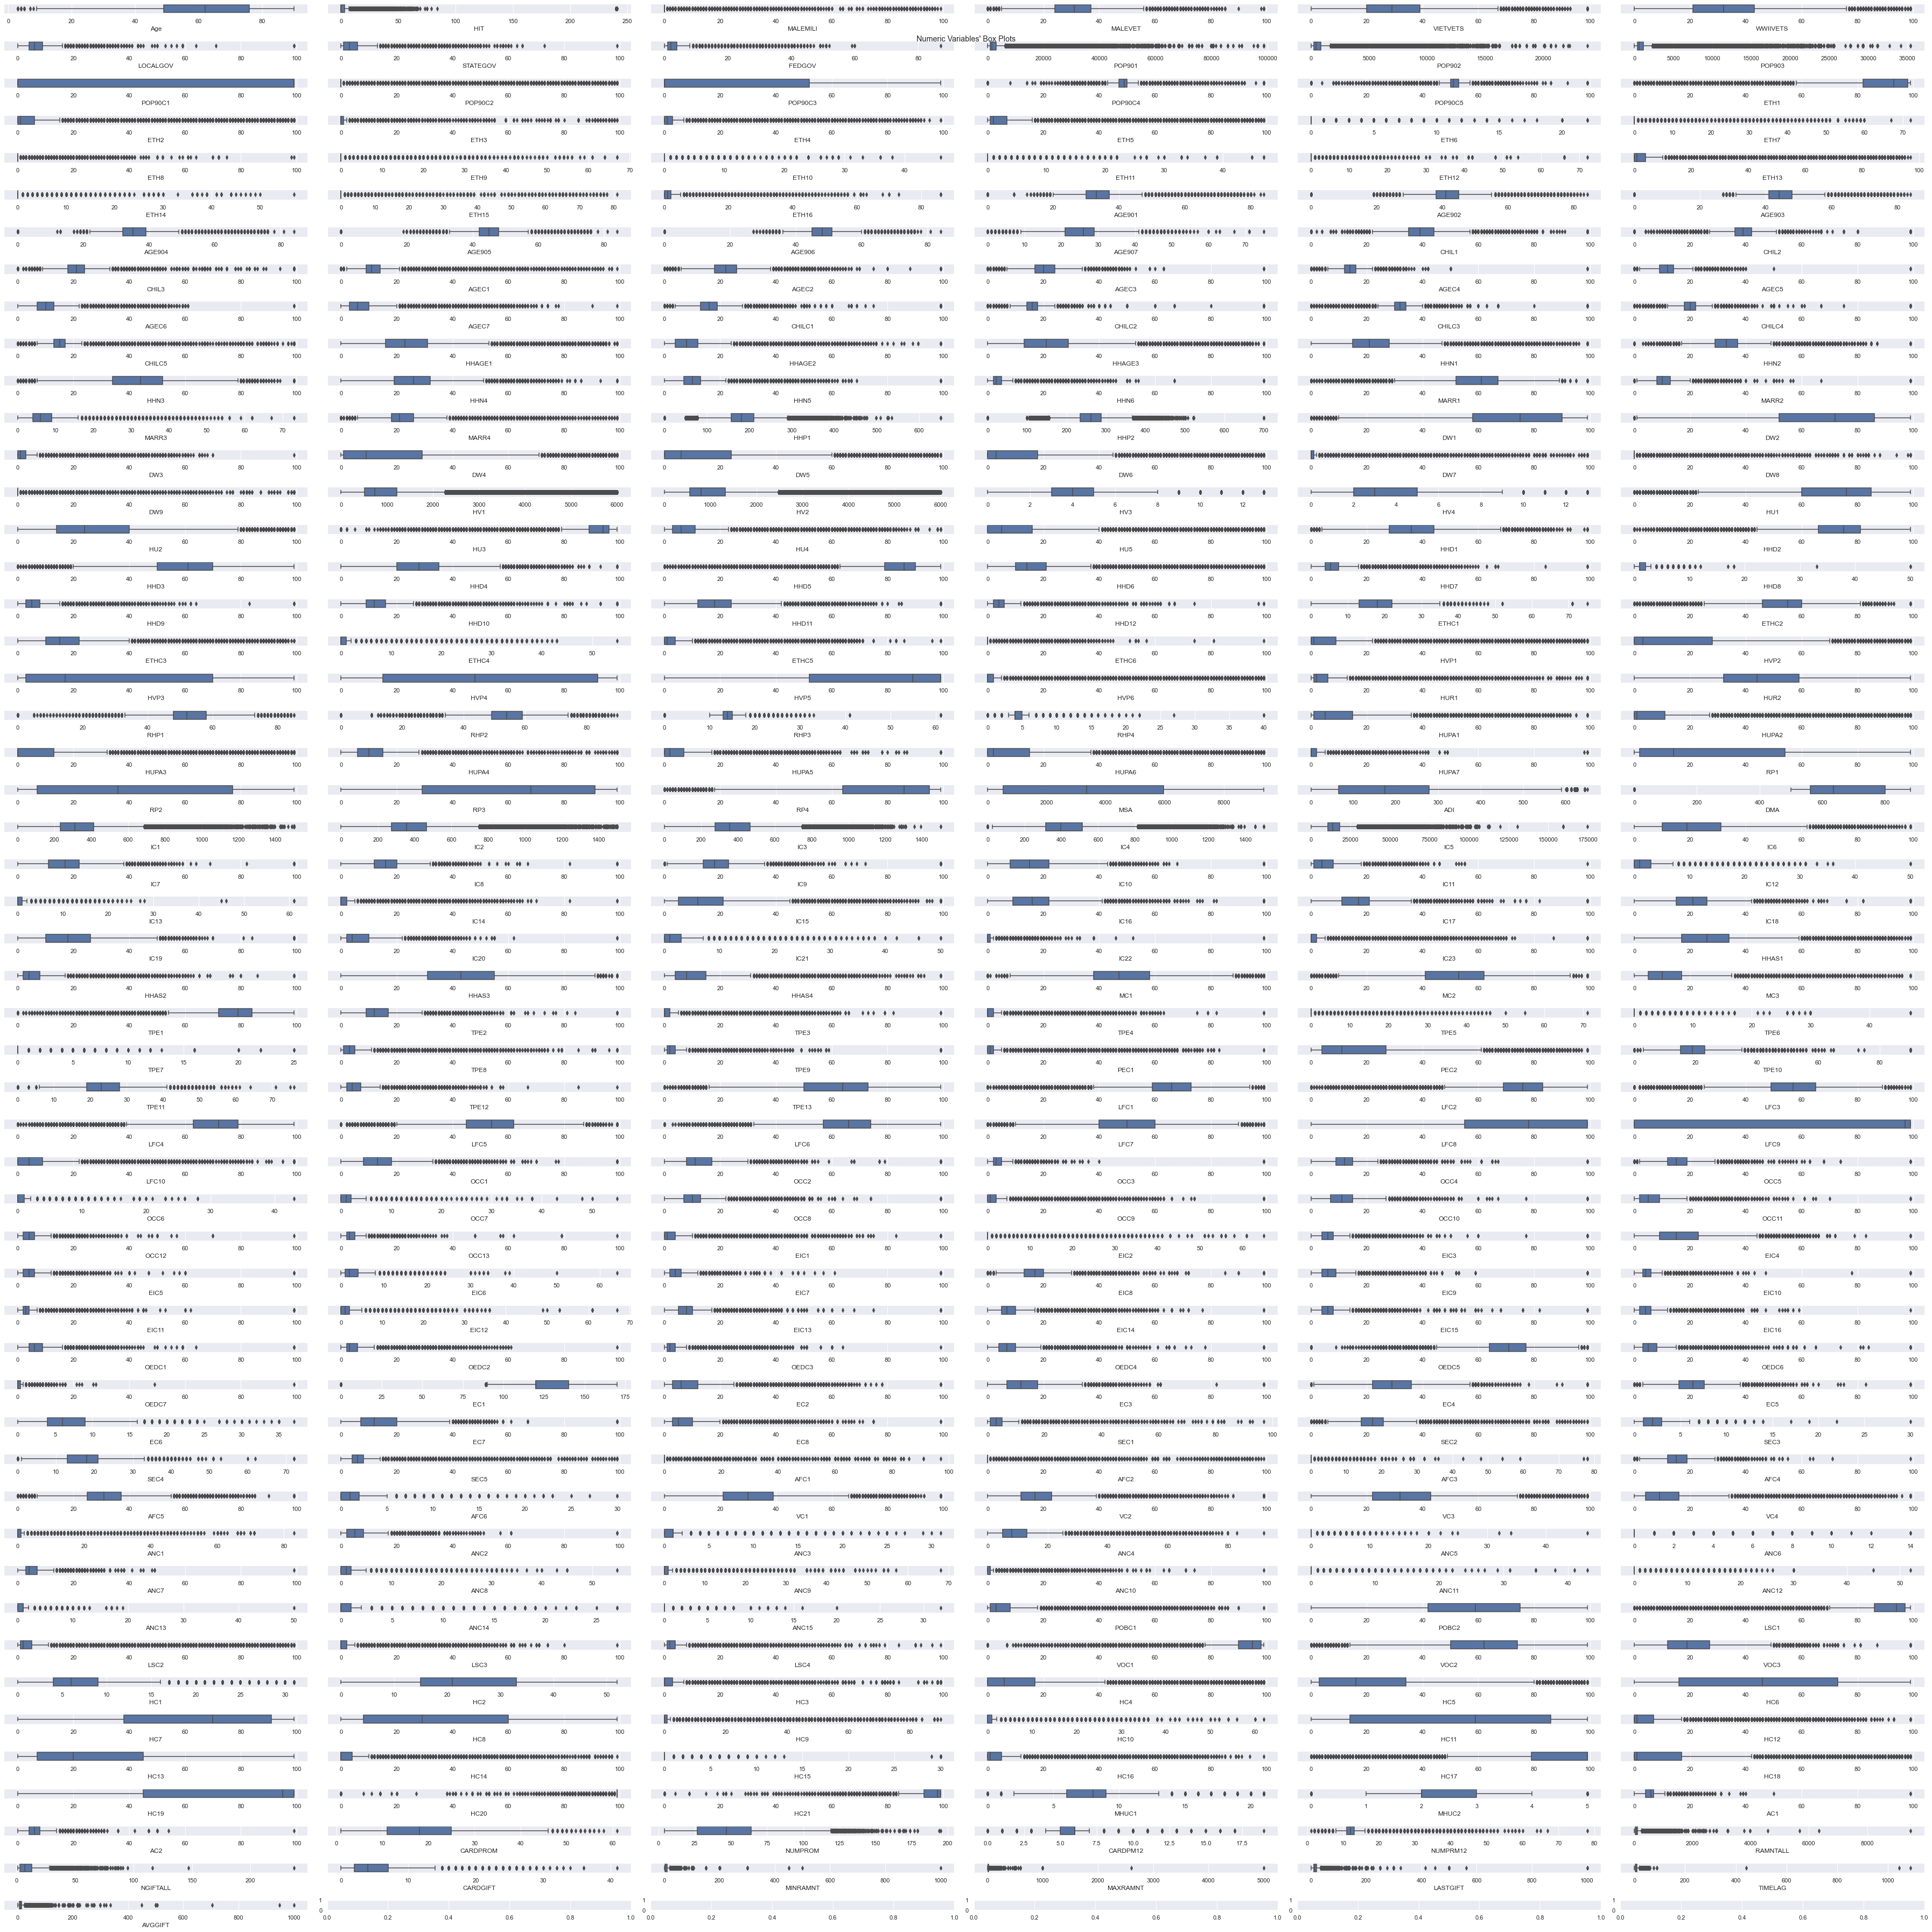

In [15]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(52, ceil(len(metric_features) / 52), figsize=(50, 50), squeeze=True)

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), metric_features): 
    sns.boxplot(x=df[feat], ax=ax)
#     ax.set_title(feat, y=-0.21)

# Adjusting my subplots:
fig.tight_layout()

# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"
plt.suptitle(title)

plt.show()

Steps:
- 1)Impute the missing values with the median for the metric features and mode for the non metric, because those measures are robust to outliers
- 2)Drop outliers using the Local Outlier Factor method or/and its intersection with the methods IQR and z-score
- 3)Now that we don´t have outliers anymore we can use a better method for the missing data imputation
- 4)After the feature selection we can go back and only drop the outliers on the variables that we kept

Creating an auxiliary df ( so that later I can use another method for the data imputation), and Filling the Categorical Variables with the mode and the Numeric Variables with the Median

In [16]:
aux_df = df.copy()

for column in aux_df[metric_features]:
    aux_df[column] = aux_df[column].fillna(aux_df[column].median())

Now, I can drop the outliers on our original df, based on our aux_df without missing values:

In [17]:
# Dealing with outliers on the metric features:
from sklearn.neighbors import LocalOutlierFactor

# we are only finding out outliers among the metric features:
aux_df = aux_df[metric_features]
# identifying outliers in our dataset
lof = LocalOutlierFactor()
yhat = lof.fit_predict(aux_df.values)

# select all rows that are not outliers
mask = yhat != -1

# variable that contains the original number of observations:
numero_obs_original = df.shape[0]
df = df.drop(index=aux_df.iloc[~mask, :].index)


print('% eliminated=',(1-len(df)/numero_obs_original)*100,'%')

% eliminated= 1.4987632582903587 %


Now our df is free of outliers so we can make a better imputation of the missing values in the metric features

#### Later when we have done all of our feature selection, we can go back here and apply the following methods:

In [18]:
def z_score_outlier_detection(df,column):
    mean = df[column].mean()
    std = df[column].std()
    threshold = 3
    z_s = (df[column]-mean)/std
    return z_s.apply(lambda z: z>threshold) # true if outlier

In [19]:
# Defining a function that removes the outliers from the metric features, using the IQR method:
def iqr_outlier_detection(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = (q3 - q1) 
    lower_lim = q1 - 5 * iqr
    upper_lim = q3 + 5 * iqr
    return df[column].apply(lambda x: (x < lower_lim or x > upper_lim))   # true if outlier

In [20]:
# aux_df = df.copy()

# aux_df['outlier_z_score?']=False
# aux_df['outlier_iqr?']=False

# for feature in metric_features:
#     aux_df['outlier_z_score?'] = aux_df['outlier_z_score?']|z_score_outlier_detection(aux_df,feature)
#     aux_df['outlier_iqr?'] = aux_df['outlier_iqr?']|iqr_outlier_detection(aux_df,feature)

# teste =aux_df['outlier_z_score?'] & aux_df['outlier_iqr?']
# print('% to be eliminated=',(teste.sum()/95412)*100,'%')

## Fill missing values (Data imputation)

Filling the Categorical Variables with the mode and the Numeric Variables with the KNN imputer

In [21]:
# Non Metric features:
for column in df[non_metric_features]:
    df[column] = df[column].fillna(df[column].mode()[0])

# Metric features:
# Creating new df copy to explore neighbordhood imputation
df_neighbors = df.copy()

# Seeing rows with NaNs
nans_index = df_neighbors.isna().any(axis=1)
df_neighbors[nans_index]

# KNNImputer - only works for numerical varaibles
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_neighbors[metric_features] = imputer.fit_transform(df_neighbors[metric_features])

# See rows with NaNs imputed
df_neighbors.loc[nans_index, metric_features]

# let's keep the df_neighbors dataframe
df = df_neighbors.copy()

In [22]:
df.isnull().sum()

ODATEDW     0
OSOURCE     0
TCODE       0
STATE       0
ZIP         0
           ..
RFA_2A      0
MDMAUD_R    0
MDMAUD_F    0
MDMAUD_A    0
GEOCODE2    0
Length: 408, dtype: int64

# Metric Features

## Low Variance

Removing variables with low Variance

Done on a scaled data using MinMax Scaler

If the variance is too low, it means that it does not change much and hence it can be ignored


#### -> Function that plots Histograms of a set of variables:

In [23]:
def histograms(df,features, bins='auto',figsize=(15, 8)):
    # Put this Variables' Histograms in one figure
    sns.set()

    # Prepare figure. Create individual axes where each histogram will be placed
    fig, axes = plt.subplots(ceil(len(features) / 4),4, figsize=figsize)

    # Plot data
    # Iterate across axes objects and associate each histogram:
    for ax, feat in zip(axes.flatten(), features):
        ax.hist(df[feat], bins=bins)
        ax.set_title(feat, y=-0.17)

    # Layout
    # Add a centered title to the figure:
    title = "Variables' Histograms"
    plt.suptitle(title)
    plt.show()

In [24]:
# Scalling our data:
scaler = MinMaxScaler()
# transform data:
scaled = scaler.fit_transform(df[metric_features])
scaled = pd.DataFrame(scaled,columns = metric_features)

The following are redundant variables because of their low variance:
 ['ETH7', 'ETH10', 'ETH11', 'ETH12', 'ETH14', 'HHD8', 'IC22', 'TPE6', 'TPE7', 'OCC3', 'OCC6', 'OEDC7', 'AFC3', 'ANC1', 'ANC5', 'ANC10', 'ANC11', 'ANC15', 'HC15', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'TIMELAG', 'AVGGIFT']


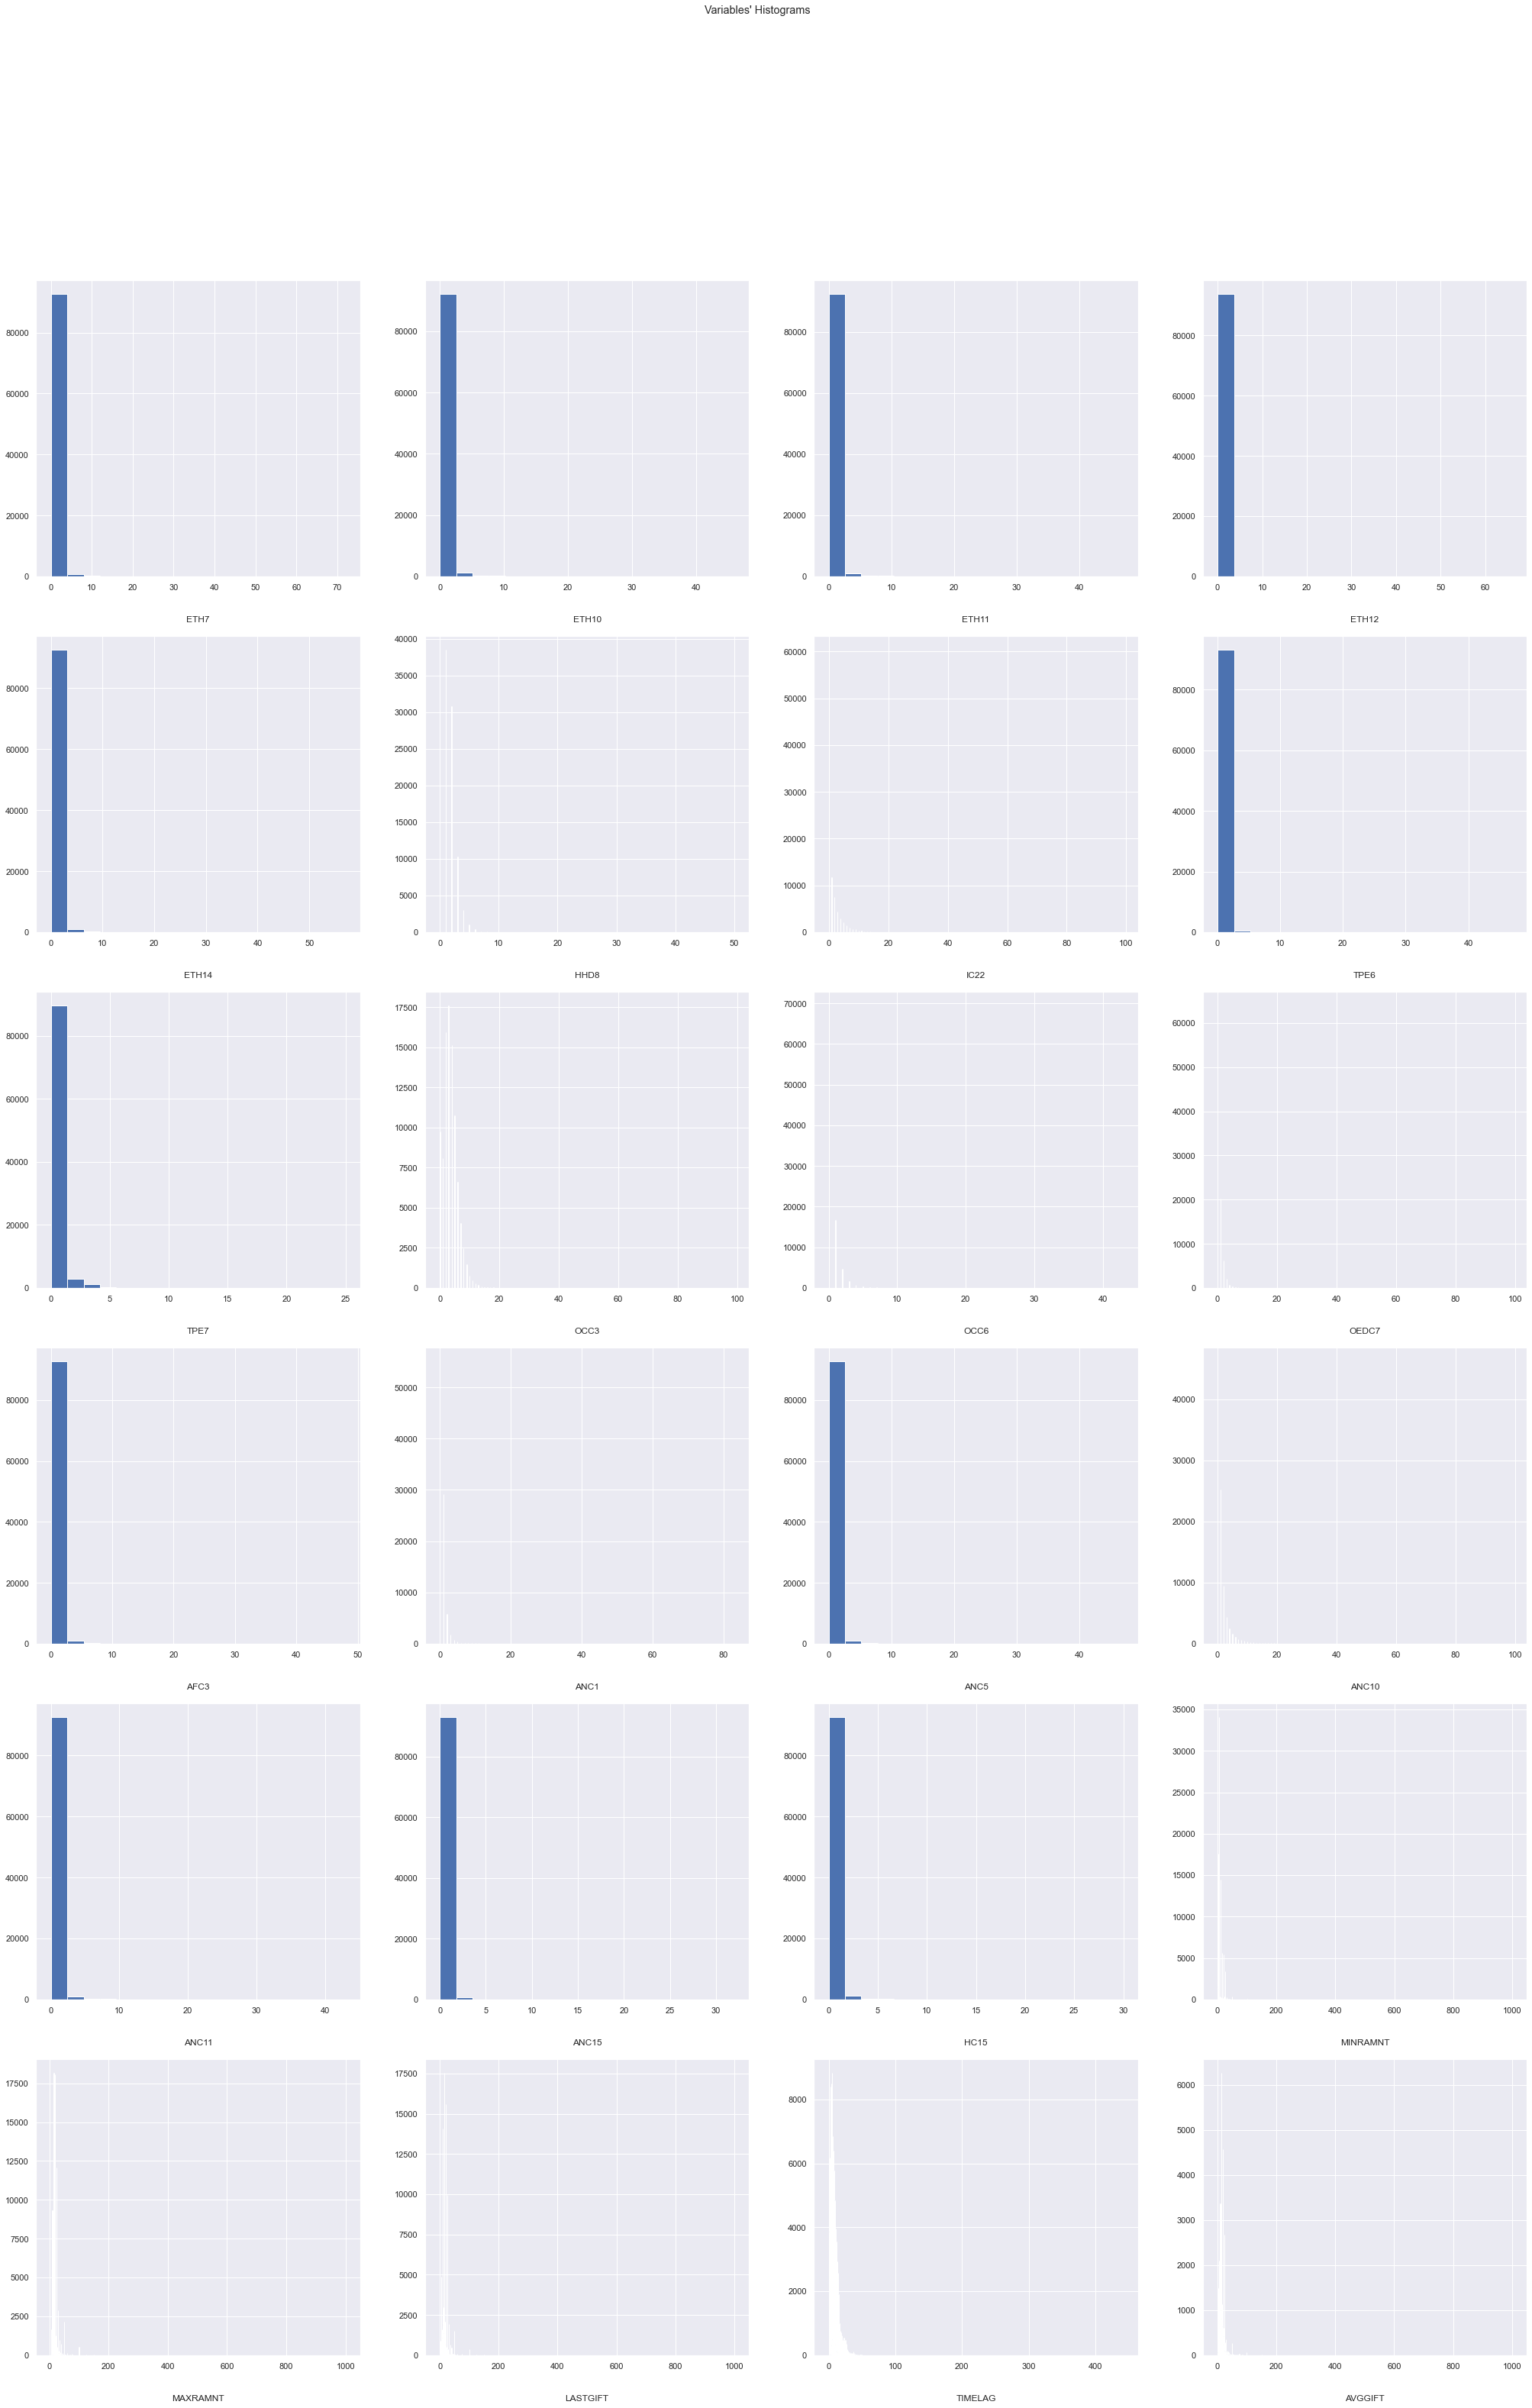

In [25]:
low_variance_features = []
for feature in metric_features:
    if (scaled[feature].var())<0.0009:
        low_variance_features.append(feature)

print('The following are redundant variables because of their low variance:\n',low_variance_features)

#Plotting an histogram of those variables:
histograms(df,low_variance_features, bins='auto',figsize=(35, 50))

# Dropping (note: I wont drop the boolean variable HPHONE_D because it only takes 0 and 1 values so it will easily have a std 
# value above my threshold, but I won´t consider it has being redundant):
df.drop(columns=low_variance_features, inplace=True)

#updating metric features list:
metric_features = update_metric_feat(df)[0]



In [26]:
display(pd.DataFrame(scaled[metric_features].var(), columns=['Variance']).sort_values(by='Variance'))

,Variance
HUPA7,0.000914
ETH6,0.000940
EIC7,0.000963
ANC12,0.000971
ANC9,0.000982
...,...
HVP3,0.136426
HVP4,0.137230
POP90C3,0.163991
LFC9,0.203652


## Correlation
Remove the features that have high correlation values (threshold of 70%) -> To avoid multicolinearity

For each pair of correlated features, our method identifies one of the features for removal (because we only need to remove one of them)

Make visualization with the high correlations (ex:heatmap that shows all the features that have at least one correlation above the threshold)

Make list of correlated features that will be removed, or show the highly correlated pairs of features in a dataframe

Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. So, when two features have high correlation, we can drop one of the two features

#### -> Function that plots an heatmap of the correlation matrix passed as input

In [27]:
def corr_heatmap(corr):    
    # Prepare figure
    fig = plt.figure(figsize=(50, 30))
    # Build annotation matrix (values above |0.7| will appear annotated in the plot)
    mask_annot = np.absolute(corr.values) >= 0.7
    annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))
    # Plot heatmap of the correlation matrix
    sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
                fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5, annot_kws={"size": 10})
    # Layout
    fig.subplots_adjust(top=0.95)
    fig.suptitle("Correlation Matrix", fontsize=20)
    plt.show()

#### -> Handling with highly correlated Features:

The features to be removed because of their high correlation are:
 ['POP902', 'POP903', 'POP90C3', 'ETH2', 'ETH8', 'ETH13', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906', 'AGEC6', 'AGEC7', 'CHILC1', 'CHILC2', 'CHILC3', 'CHILC5', 'HHAGE1', 'HHAGE2', 'HHAGE3', 'HHN1', 'HHN2', 'HHN3', 'HHN4', 'HHN5', 'HHN6', 'MARR3', 'MARR4', 'HHP1', 'HHP2', 'DW2', 'DW4', 'DW5', 'DW6', 'DW8', 'HV2', 'HV3', 'HV4', 'HU1', 'HU2', 'HU4', 'HHD1', 'HHD2', 'HHD3', 'HHD4', 'HHD5', 'HHD6', 'HHD9', 'HHD10', 'HHD11', 'HHD12', 'ETHC1', 'ETHC2', 'ETHC3', 'ETHC4', 'ETHC5', 'ETHC6', 'HVP1', 'HVP2', 'HVP3', 'HVP4', 'HVP5', 'HVP6', 'HUR2', 'RHP1', 'RHP2', 'RHP3', 'HUPA1', 'HUPA2', 'HUPA5', 'HUPA6', 'HUPA7', 'RP1', 'RP2', 'RP3', 'RP4', 'IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6', 'IC10', 'IC11', 'IC12', 'IC14', 'IC15', 'IC16', 'IC17', 'IC18', 'IC19', 'IC20', 'IC21', 'IC23', 'HHAS1', 'HHAS3', 'HHAS4', 'MC2', 'TPE4', 'TPE11', 'TPE12', 'TPE13', 'LFC2', 'LFC3', 'LFC4', 'LFC5', 'LFC7', 'OCC2', 'EIC1', 'EIC4', 'OEDC1', 'OEDC2', 

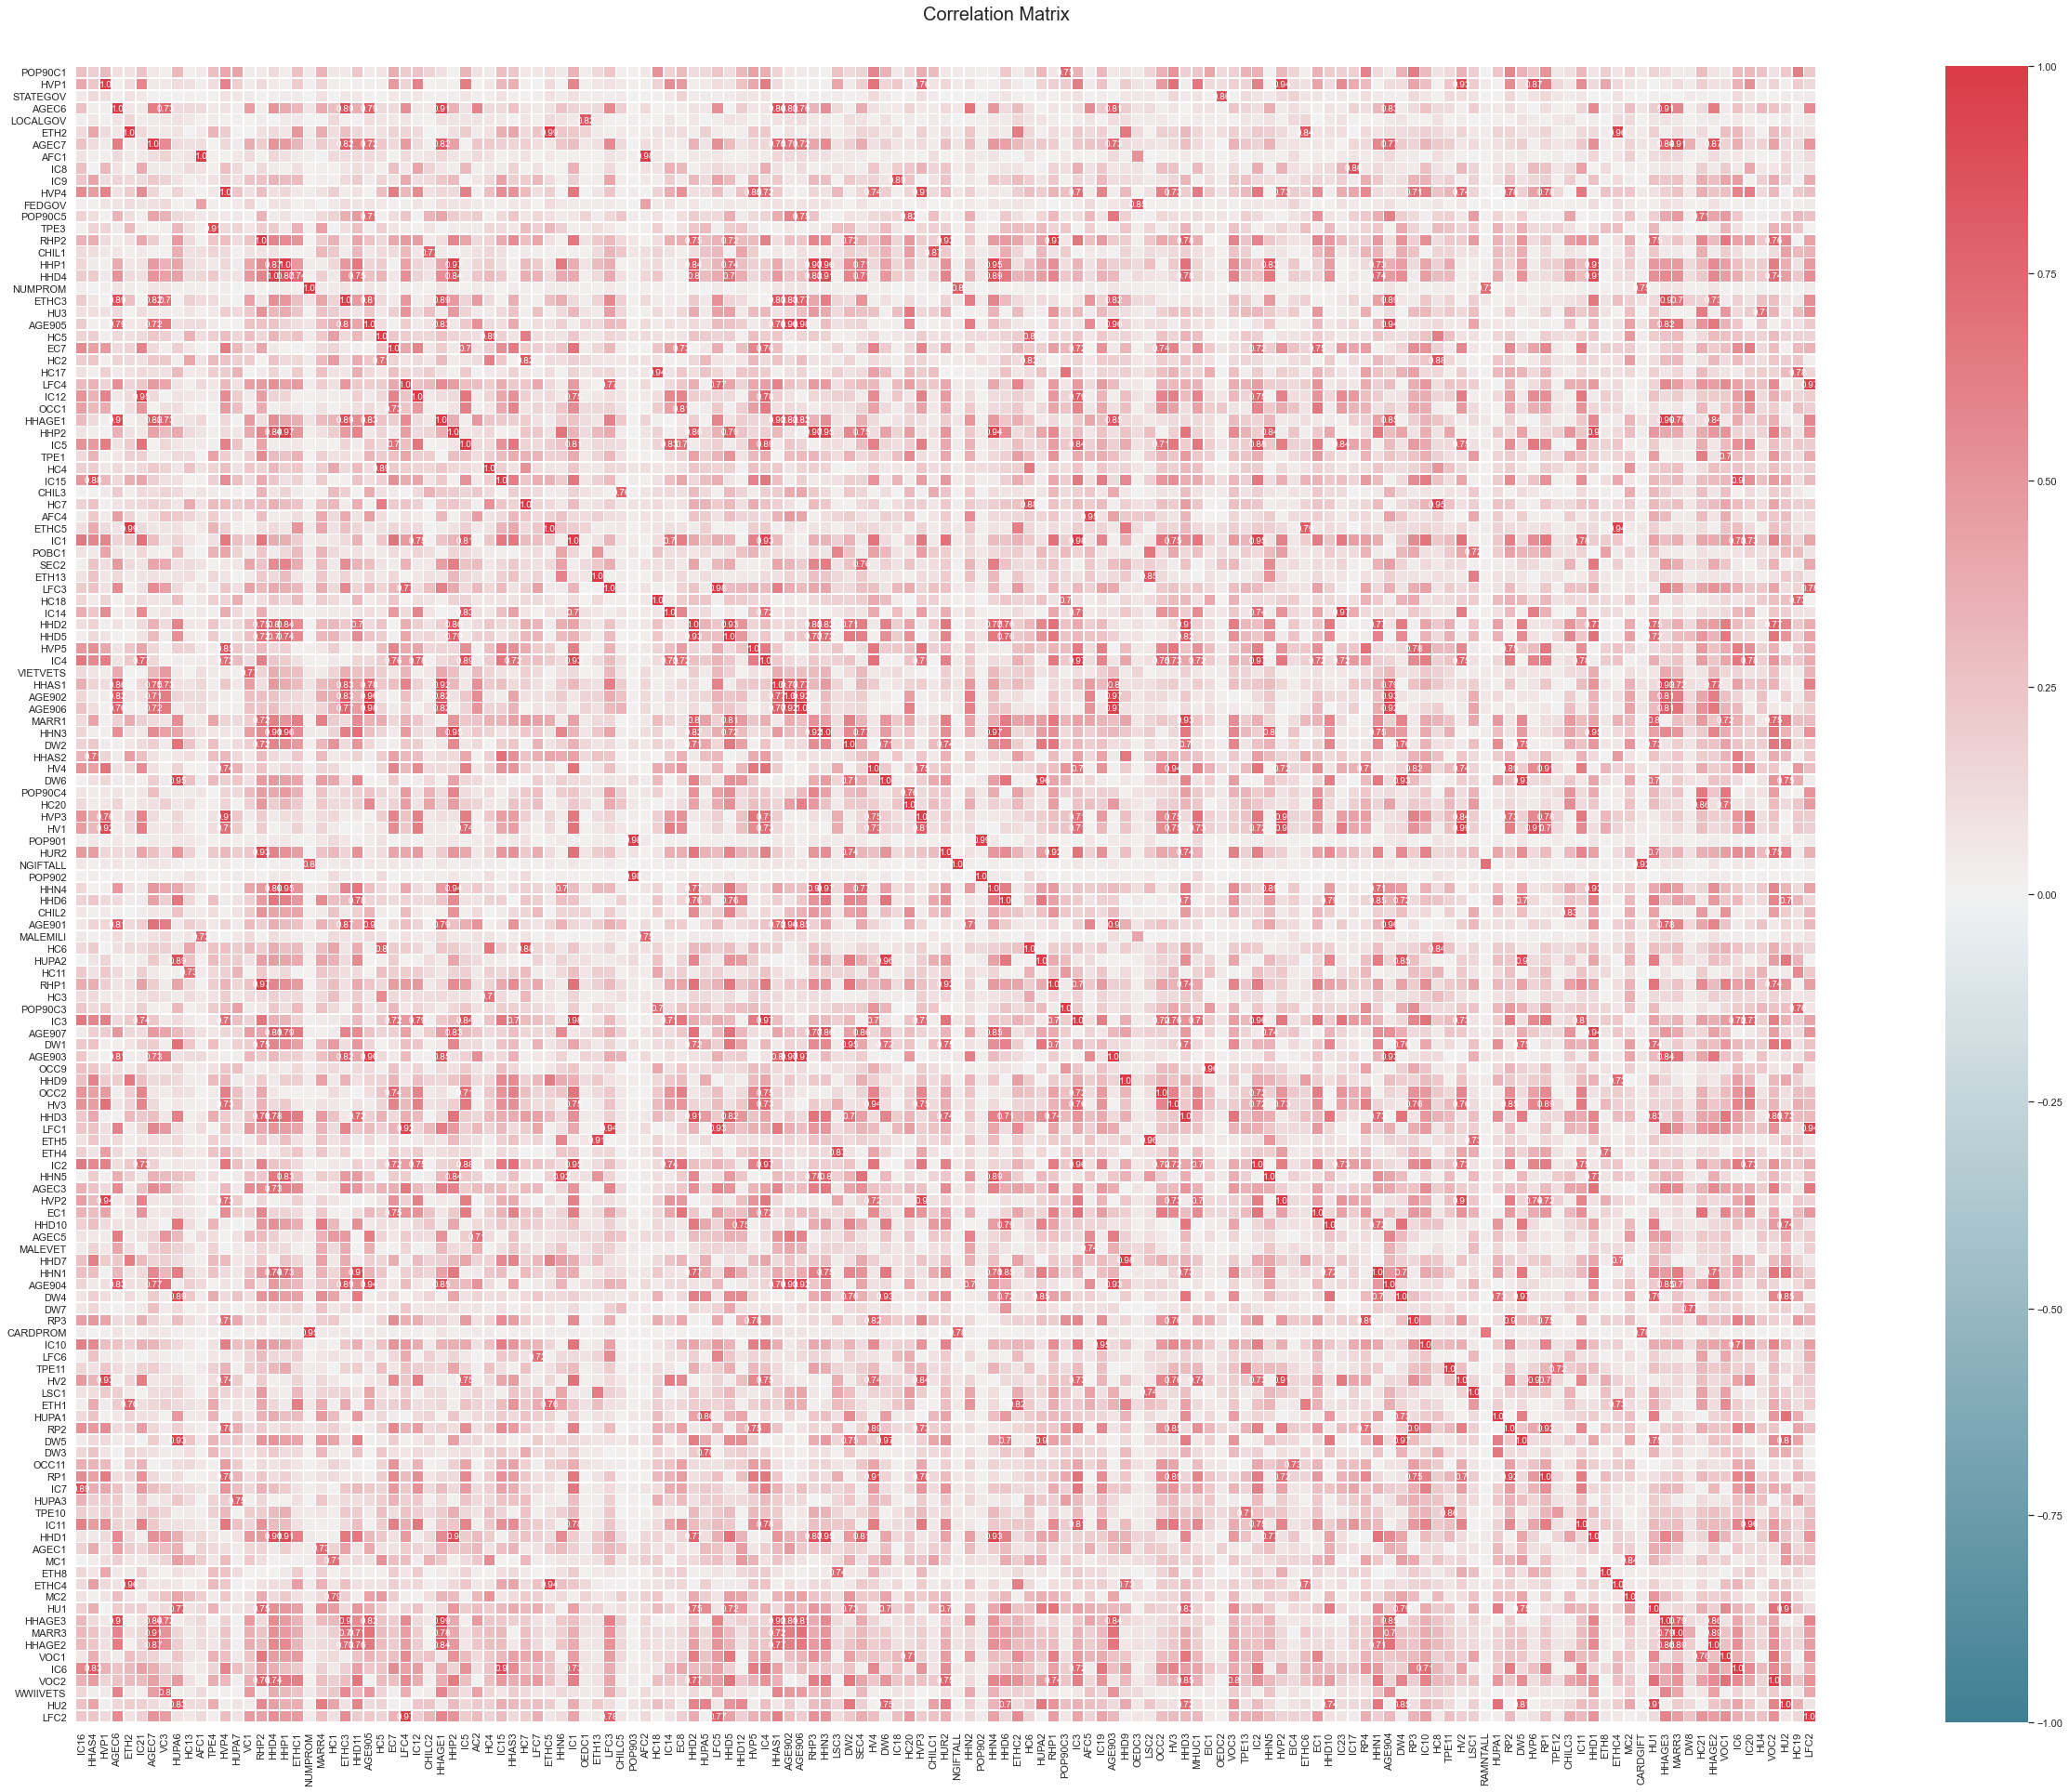

In [28]:
# Creating correlation matrix with the absolute values of the corr:
corr = df.corr().abs()

# Selecting upper triangle of the correlation matrix:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Finding the index of the feature's columns with correlation greater than 0.70 (>=very strong correlation)
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

print('The features to be removed because of their high correlation are:\n',to_drop)

# Saving the pairs of correlated features so I can plot an heatmap of their correlations:

# I´ll save both the dropped feature and the one that was correlated with it:
records = pd.DataFrame(columns = ['dropped_feat', 'corr_feat'])
for column in to_drop:
    corr_features = list(upper.index[upper[column].abs() > 0.7])
    drop_features = [column for _ in range(len(corr_features))]
    # Record the information (need a temp df for now)
    aux_df = pd.DataFrame.from_dict({'dropped_feat': drop_features,'corr_feat': corr_features})

    # Add to dataframe
    records = records.append(aux_df, ignore_index = True)


corr_matrix_plot = corr.loc[list(set(records['corr_feat'])),list(set(records['dropped_feat']))]
title = "Correlations Above Threshold"
# * the features on the x axis are the ones that are going to be removed


# Plotting an heatmap:
corr_heatmap(np.round(corr_matrix_plot,decimals=2))


# Dropping the highly correlated features 
df.drop(columns = to_drop, inplace=True)

# updating metric features list:
metric_features = update_metric_feat(df)[0]

#### Some explanations

[Handle with variables of central tendency measures]

Once there are variables that provide the same information but in different measures, we decide to keep the variables that refer to the median because it's less sensitive to outliers and remove the others ones in these specific cases.

One example of the situation described above is the variable HHP1 (Median Person Per Household) and HHP2 (Average Person Per Household).


[Handle with redundant variables]

Since there are variables that have repeated information, that is, variables that englobe other variables, let's take into consideration, for example, HHN3 (Percent 3 or More Person Households) and HHN4 (Percent 4 or More Person Households). We can soon conclude that HHN4 is mentioned in HHN3, once 'more than 3' englobe the percent of 4 and so on.

In these particular cases, we decide to keep the variables that provide the same meaning as the others of the same kind, without losing information, and discard the ones that are already indirectly specified in the ones that we chose to keep.

# Categorical Features

#### -> Pieplots

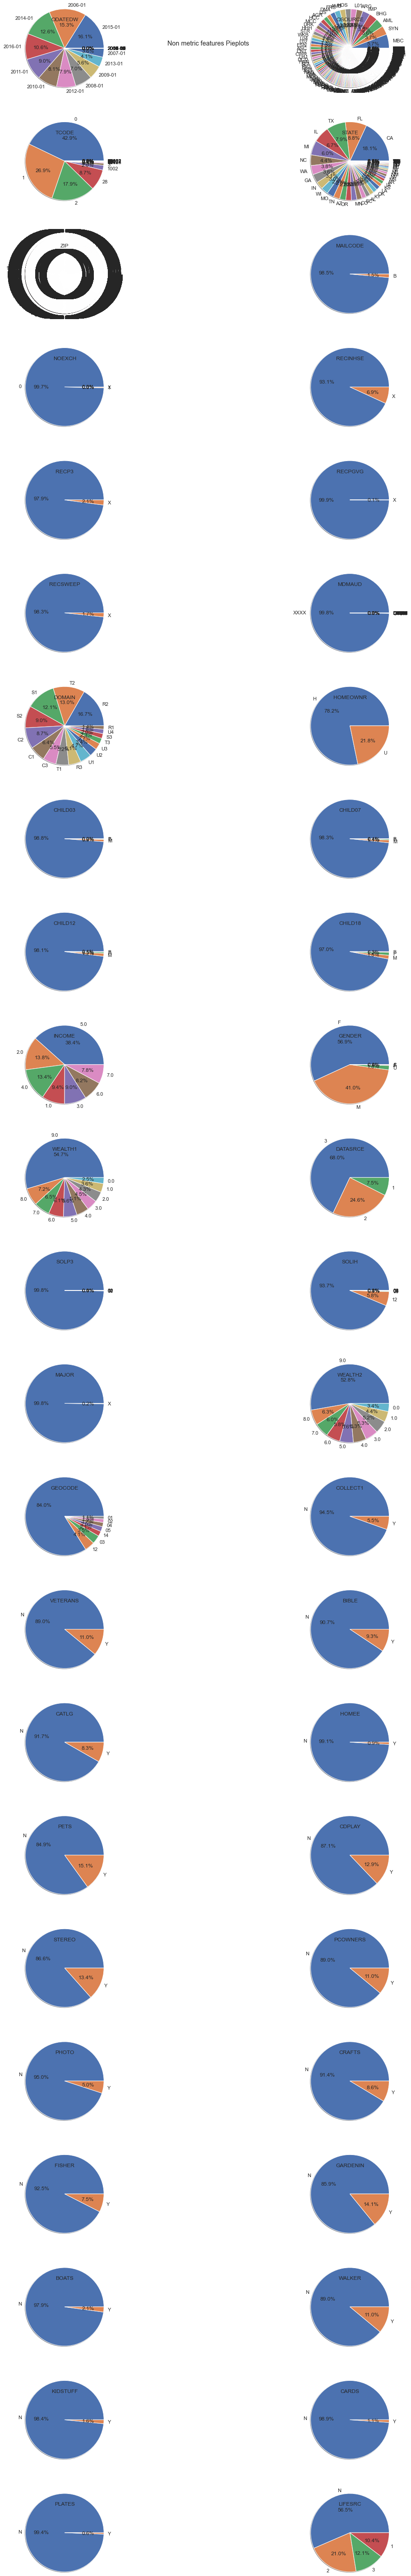

In [29]:
# import plotly.express as px
# from plotly.subplots import make_subplots

# # Prepare figure. Create figures where each pieplot will be placed
# # use 'domain' type for Pie subplot
# for feat in non_metric_features:
#     fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
#     fig=px.pie(df[feat], names=feat, title=feat)
#     fig.show()

sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(23, 2, figsize=(20, 80))

# Plot data
# Iterate across axes objects and associate each histogram:
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    ax.pie(df[feat].value_counts().values,labels=df[feat].value_counts().index,autopct='%1.1f%%', shadow=True, radius=2)
    ax.set_title(feat)
fig.tight_layout()
# Layout
# Add a centered title to the figure:
title = " Non metric features Pieplots"
plt.suptitle(title)
plt.show()

#### -> Single Value Features

In [30]:
# get number of unique values for each column using numpy
counts = list(df.nunique())
names = list(df.nunique().index)

def create_dict(keys, values): 
    return dict(zip(keys, values + [None] * (len(keys) - len(values))))
columns = create_dict(names, counts)

# record columns to delete
to_del = dict((k, v) for k, v in columns.items() if v == 1) 
to_del

{'ADATE_5': 1, 'RFA_2R': 1}

#### -> Remove the variables that for one category have more than 85% of the observations:

In [31]:
to_drop=[]
for feature in non_metric_features:
    for proportion in df[feature].value_counts()/len(df):
        if proportion > 0.85:
            to_drop.append(feature)
            break

print('The non metric features that have more than 85% in one of their categories/unique values (to be dropped because \
of their redundancy) are the following:\n',to_drop)

df.drop(columns=to_drop, inplace=True)

# updating non metric features list:
non_metric_features = update_metric_feat(df)[1]

The non metric features that have more than 85% in one of their categories/unique values (to be dropped because of their redundancy) are the following:
 ['MAILCODE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP', 'MDMAUD', 'CHILD03', 'CHILD07', 'CHILD12', 'CHILD18', 'SOLP3', 'SOLIH', 'MAJOR', 'COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES', 'ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7', 'ADATE_8', 'ADATE_9', 'ADATE_10', 'ADATE_13', 'ADATE_14', 'ADATE_16', 'ADATE_17', 'ADATE_19', 'ADATE_21', 'ADATE_22', 'ADATE_24', 'MAXADATE', 'RFA_2R', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A']


#### ->Drop the categorical features with high variability , in case none of its categories have more than 15%:

In [32]:
to_drop=[]
for feature in non_metric_features:
    aux =[]
    for proportion in df[feature].value_counts()/len(df):
        if proportion < 0.15:
            aux.append(proportion)
    if len(aux)==len(df[feature].value_counts()): # if all categories have less than 10%;
        to_drop.append(feature)

print('The non metric features that have less than 10% in all of their categories/unique values (to be dropped because \
of their redundancy) are the following:\n',to_drop)

df.drop(columns=to_drop, inplace=True)

# updating non metric features list:
non_metric_features = update_metric_feat(df)[1]

The non metric features that have less than 10% in all of their categories/unique values (to be dropped because of their redundancy) are the following:
 ['OSOURCE', 'ZIP', 'MINRDATE', 'MAXRDATE', 'FISTDATE', 'NEXTDATE']


### Reduce Cardinality of the Categorical features and one hot encoding

https://www.youtube.com/watch?v=MPnNC6kkNC4
https://www.youtube.com/watch?v=6WDFfaYtN6s

### MCA

## Going back to the numerical features

- Nota: Meter os outliers das vars q removemos outra vez e fazer o IQR e zscore apenas nas variaveis que mantemos

### Scale/Standardize our data

In [33]:
df_standard = df.copy()
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_standard[metric_features])
scaled_feat

array([[ 0.09008155, -0.35706363, -0.21599227, ...,  1.00036069,
         0.53672762,  0.26236217],
       [-0.90585175,  1.35429792, -0.21599227, ..., -0.74992288,
         0.53672762,  0.03894806],
       [-0.40124555, -0.14314343, -0.21599227, ...,  0.88367512,
         0.53672762,  0.26236217],
       ...,
       [-0.77306065, -0.25010353, -0.21599227, ..., -1.68340744,
        -1.92838291, -1.07812246],
       [ 0.02368599, -0.35706363, -0.21599227, ..., -0.51655173,
         1.35843113,  0.93260448],
       [-0.10910511, -0.35706363, -0.21599227, ...,  2.05053083,
         3.00183815,  4.06040194]])

In [34]:
# See what the fit method is doing :
print("Parameters fitted:\n", scaler.mean_, "\n", scaler.var_)

Parameters fitted:
 [6.16432593e+01 3.33828818e+00 1.00360707e+00 3.05560426e+01
 2.97687217e+01 3.27061352e+01 6.85204614e+00 4.55186099e+00
 3.09408185e+00 3.24107122e+03 5.85598944e+01 1.36223213e+01
 4.81812794e+01 5.10181205e+01 8.50640867e+01 7.50835266e-01
 2.83896916e+00 7.40288566e+00 2.14764529e-01 5.46806835e-01
 3.27498883e-01 1.49807410e+00 3.44974889e+01 2.46050946e+01
 3.95839629e+01 3.84351791e+01 2.10321338e+01 1.20957098e+01
 2.21621906e+01 2.07031772e+01 1.41119257e+01 1.18997787e+01
 1.98116129e+01 5.83350535e+01 1.06684046e+01 7.04810389e+01
 2.89681003e+00 1.62677960e+00 5.17056458e-01 1.05761243e+03
 9.00669490e+01 1.37451427e+01 7.88494605e+00 4.67605499e+00
 4.38596753e+00 8.56177779e+00 1.11255560e+01 3.53469275e+03
 1.87799093e+02 6.63945219e+02 1.69018961e+01 1.57751165e+01
 1.84083654e+01 9.37551872e-01 6.07746164e+00 4.82279798e+01
 1.21656807e+01 7.63930540e+01 1.30185248e+01 2.33087187e+00
 4.45638527e-01 3.92842246e+00 3.24928178e+00 2.27920240e+00
 1.8

In [35]:
df_standard[metric_features] = scaled_feat
df_standard.head()

,,ODATEDW,TCODE,STATE,Age,DOMAIN,HOMEOWNR,INCOME,GENDER,WEALTH1,HIT,...,RFA_22,RFA_24,CARDPROM,CARDPM12,NUMPRM12,LASTDATE,HPHONE_D,RFA_2F,RFA_2A,GEOCODE2
,CONTROLN,,,,,,,,,,,,,,,,,,,,,
0,95515,2009-01,0,IL,0.090082,T2,H,5.0,F,9.0,-0.357064,...,S4E,S4E,1.000361,0.536728,0.262362,2015-12-01,0,4,E,C
1,148535,2014-01,1,CA,-0.905852,S1,H,6.0,M,9.0,1.354298,...,N1E,F1E,-0.749923,0.536728,0.038948,2015-12-01,0,2,G,A
2,15078,2010-01,1,NC,-0.401246,R2,U,3.0,M,1.0,-0.143143,...,S4D,S3D,0.883675,0.536728,0.262362,2015-12-01,1,4,E,C
3,172556,2007-01,0,CA,0.687642,R2,U,1.0,F,4.0,-0.143143,...,A1D,A1E,1.000361,0.536728,0.262362,2015-12-01,1,4,E,C
4,7112,2006-01,0,FL,1.218806,S2,H,3.0,F,2.0,6.060542,...,I4E,A3D,2.867330,3.823542,2.719917,2016-01-01,1,2,F,A


In [36]:
# Checking mean and variance of standardized variables
df_standard[metric_features].describe().round(2)

,Age,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,POP901,...,HC11,HC12,HC14,HC16,HC17,MHUC2,AC1,CARDPROM,CARDPM12,NUMPRM12
count,93982.00,93982.00,93982.00,93982.00,93982.00,93982.00,93982.00,93982.00,93982.00,93982.00,...,93982.00,93982.00,93982.00,93982.00,93982.00,93982.00,93982.00,93982.00,93982.00,93982.00
mean,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,...,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.89,-0.36,-0.22,-2.69,-1.98,-1.86,-1.59,-0.90,-0.76,-0.57,...,-1.46,-0.57,-0.48,-0.51,-2.91,-2.75,-2.08,-2.03,-4.39,-2.64
25%,-0.64,-0.36,-0.22,-0.49,-0.65,-0.66,-0.66,-0.70,-0.51,-0.39,...,-1.07,-0.57,-0.48,-0.51,-0.13,-0.40,-0.66,-0.87,-0.28,-0.41
50%,0.02,-0.36,-0.22,0.04,-0.05,-0.04,-0.20,-0.31,-0.27,-0.29,...,0.20,-0.49,-0.48,-0.41,0.58,-0.40,0.05,-0.05,0.54,-0.18
75%,0.75,-0.04,-0.22,0.57,0.61,0.58,0.50,0.29,0.22,-0.03,...,0.95,0.01,-0.06,-0.03,0.58,0.77,0.41,0.77,0.54,0.04
max,1.88,25.42,20.66,6.02,4.61,3.77,21.32,18.64,20.58,16.68,...,1.32,7.64,9.53,8.54,0.58,3.13,15.68,4.97,11.22,14.56


In [37]:
df = df_standard.copy()

### Apply kmeans for feature selection (using it to find the clusters which then are my target variable)

In [ ]:
# Defining the number of clusters:
range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df[metric_features])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution
    
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [ ]:
# final cluster solution
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=0)
km_labels = kmclust.fit_predict(df[metric_features])
df_concat = df.copy() 
df_concat['labels']=km_labels
df_concat

In [ ]:
# Lasso regression
# separating the income variable from the independent numeric variables:
data = df_concat[metric_features].iloc[:,:-1]
target = df_concat.iloc[:,-1]

reg = LassoCV()
reg.fit(X = data, y = target)

# The alpha value is associated to the regularization strength. Regularization improves the conditioning of the problem and 
# reduces the variance of the estimates. Larger values specify stronger regularization:
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)

# The score return the coefficient of determination R^2 of the prediction:
print("Best score using built-in LassoCV: %f" %reg.score(data,target))

# coef will have as index the data columns names and the coef_ attribute as value:
coef = pd.Series(reg.coef_, index = data.columns)
coef

In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
coef.sort_values()

In [ ]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(55,55))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    
    plt.show()

plot_importance(coef, "Lasso")

In [ ]:
# Ridge classifier
ridge = RidgeClassifierCV().fit(X = data,y = target)
coef_ridge = pd.Series(ridge.coef_[0], index = data.columns)
plot_importance(coef_ridge,'RidgeClassifier')

ridge.score(data,target)

### PCA

In [ ]:
df_pca = df.copy()

# Use PCA to reduce dimensionality of data
pca = PCA()
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat  

In [ ]:
print(pca_feat.shape)
print(df_pca[metric_features].shape)
pd.DataFrame(pca_feat)

In [ ]:
cov_matrix = df_pca[metric_features].cov()
cov_matrix

In [ ]:
# Composing back the covariance matrix
pd.DataFrame(pca.components_.T @ np.diag(pca.explained_variance_) @ pca.components_, 
             index=cov_matrix.index, 
             columns=cov_matrix.columns)

In [ ]:
# Obtaining the projected observations on the principal components axes (linear combinations)
pd.DataFrame(df_pca[metric_features].values @ pca.components_.T, 
             index=df_pca.index,
             columns=[f"PC{i}" for i in range(pca.n_components_)])

In [ ]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
).head(60)
# rule(pearson), de manter os que têm um eigenvalue>1
# na kaiser´s ruler queremos reter 80% da variancia, olhar para a comulative

In [ ]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(55, 25))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [ ]:
# # Perform PCA again with the number of principal components you want to retain
# pca = PCA(n_components=4)
# pca_feat = pca.fit_transform(df_pca[metric_features])
# pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
# pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
# pca_df

In [ ]:
# # Reassigning df to contain pca variables
# df_pca = pd.concat([df_pca, pca_df], axis=1)
# df_pca.head()

# # we should use the components for our analysis instead of the numeric variables

*INTERPRETATION OF THE PRINCIPAL COMPONENTS

In [ ]:
# pd.get_dummies(df[non_metric_features])
# df[non_metric_features[10:]]